## language detection

# Introduction

The problem I am going tackle here is the following: can we identify the language  with high accuracy using machine learning.
This problem is currently solved by various software libraries, but using a set of hardcoded rules and lookup tables. We will attack this problem using Machine Learning algorithms.

In [1]:
# Required libraries

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import sent_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd


# key variables

regular expression pattern used to filter out anything between < > 
remove XML tags procedure

Max length of language transcription

Ensure each language has similar amount of representation (Balanced Dataset)

labels : Map language index to natural language

language_code_variable: Map language to language code and file name

 limited_raw_text : These languages need multiple files combined to get a transcription of length.
  condition : greater or equal MAX_LENGTH_TRANSCRIPTION

In [2]:


pattern = r'<(!?).*>'


MAX_LENGTH_TRANSCRIPTION = 150000



labels = {
          1.0:'Danish', 2.0:'German',
          3.0: 'Greek', 4.0: 'English',
          5.0: 'Spanish',6.0: 'Finnish',
          7.0: 'French', 8.0: 'Italian',
          9.0: 'Dutch', 10.0: 'Portuguese',
          11.0: 'Swedish', 12.0: 'Bulgarian',
          13.0: 'Czech', 14.0: 'Estonian',
          15.0: 'Hungarian', 16.0: 'Lithuanian',
          17.0: 'Latvian', 18.0: 'Polish',
          19.0: 'Romanian', 20.0: 'Slovak',
          21.0: 'Slovenian'
          }


language_codes_files = {
    'Danish': ['da', '/ep-00-01-17.txt'], 'German': ['de', '/ep-00-01-17.txt'],
    'Greek': ['el', '/ep-00-01-17.txt'], 'English': ['en', '/ep-00-01-17.txt'],
    'Spanish': ['es', '/ep-00-01-17.txt'], 'Finnish': ['fi', '/ep-00-01-17.txt'],
    'French': ['fr','/ep-00-01-17.txt'], 'Italian': ['it', '/ep-00-01-17.txt'],
    'Dutch': ['nl', '/ep-00-01-17.txt'], 'Portuguese': ['pt', '/ep-00-01-17.txt'],
    'Swedish': ['sv', '/ep-00-01-17.txt'], 'Bulgarian': ['bg', '/Bulgarian.txt'],
    'Czech': ['cs', '/Czech.txt'], 'Estonian': ['et', '/Estonian.txt'],
    'Hungarian': ['hu', '/Hungarian.txt'], 'Lithuanian': ['lt', '/Lithuanian.txt'],
    'Latvian': ['lv', '/Latvian.txt'], 'Polish': ['pl', '/Polish.txt'],
    'Romanian': ['ro', '/Romanian.txt'], 'Slovak': ['sk', '/Slovak.txt'],
    'Slovenian': ['sl', '/Slovenian.txt']
}


limited_raw_text = ['Bulgarian', 'Czech', 'Estonian', 'Hungarian', 'Lithuanian',
                     'Latvian', 'Polish', 'Romanian', 'Slovak', 'Slovenian']



# useful functions

### combine_text_files :
                      Certain languages do not have a single file of length >= MAX_LENGTH_TRANSCRIPTION
                      This function will combine these files for this sort of language into one language
                      transcription, and then write the transcription to a single file.
          
                      @param: (string) language_code is the 2 character code of the language
          
                      @param: (string) language is the English name of the language

In [11]:
def combine_text_files(language_code, language):
    

    file_name_list = os.listdir('language_data/txt/' + language_code + '/')
    language_transcription = ''
    for file_name in file_name_list:
        if (len(language_transcription) >= MAX_LENGTH_TRANSCRIPTION):
            break;
        path = os.getcwd() + '/language_data/txt/' + language_code + '/' + file_name
        with open(path,errors="ignore") as f:
            contents = f.read()
            language_transcription += contents

    write_path = os.getcwd() + '/language_data/txt/' + language_code + '/' + language + '.txt'
    with open(write_path, 'w') as f:
        f.write(language_transcription)


### read_languages_data:
                             Read language data from file path into a list containing one big string
                             @param path: (string) file path pointing to the raw natural language text
                             @return language_transcription: (list) language_transcription is a list of one string containing all the  text
    


In [12]:
def read_languages_data(path):
    

    with open(path,errors="ignore") as file:
        language_transcription = file.read()
        language_transcription = language_transcription[:MAX_LENGTH_TRANSCRIPTION]
    return language_transcription

### clean_sentences:
                        remove XML tags procedure using regular expression pattern
                        @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                        Note: The raw language_transcription should be tokenized by sentence prior
                        to being passed into this function.


In [13]:
def clean_sentences(sentences):

    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(pattern, '', sentence)

### combine_language_data:
                                 Transform list of string sentences into np.array, and stack horizontally with an np.array
                                 containing the sentence's language_index, which maps to the sentence language. 
                                 Essentially, apply label to data.
                                 @param sentences: (list) sentences is a list of strings that has had speaker information
                                 filtered out
                                 @param language_index: (float) language_index is a float that maps to a specific language in
                                 the labels dictionary
                                 @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
                                 

In [14]:
def combine_language_data(sentences, language_index):

    sentences = np.array(sentences)
    sentences = sentences.reshape(sentences.shape[0], 1)
    target = np.zeros((sentences.shape[0], 1))
    target += language_index
    language_data = np.hstack((sentences, target))
    return language_data

### test_languages:
                      Visualize the ~99% prediction accuracy by comparing,
                        1. natural language sentence
                        2. predicted natural language
                        3. true natural language
                      @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
                      @param true_values: (np.array) true_values is a np.array containing the true language_index labels
                      @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels

In [15]:
def test_languages(X_test, true_values, predictions):


    true_values = np.array(true_values)

    for i, sentence in enumerate(X_test):
        prediction = float(predictions[i])
        true_value = float(true_values[i])
        print("Prediction: " + str(labels[prediction]))
        print("Actual Language: " + str(labels[true_value]))
        print("Input Sentence: ")
        print(sentence)
        print('\n')

### shuffle_rows:
                   Shuffle rows of 2D np.array with language data
                   @param languages: un-mixed 2D np.array with language sentence features, and language_index labels
                   @return shuffled_languages: shuffled by row, 2D np.array

In [16]:
def shuffle_rows(languages):
    
    index = np.arange(0, len(languages))
    np.random.shuffle(index)
    shuffled_languages = languages[index, :]

    return shuffled_languages


### preproccess_raw_data:
                              Run all data preprocessing helper functions
                              @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                              points to a raw text file from the European Parliament Proceedings.
                              @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                              The first dimension has the a sentence, and the second dimension
                              has the language_index label, that maps to the language.


In [17]:
def preproccess_raw_data(file_paths):


    # Combine transcriptions of subset languages into a single file to ensure
    # each file will have len >= MAX_LENGTH_TRANSCRIPTION
    language_codes_files_subset = dict(
        (key, language_codes_files[key]) for key in limited_raw_text if key in language_codes_files)
    for language in language_codes_files_subset.keys():
        combine_text_files(language_codes_files_subset[language][0], language)

    # Read all raw text data from file paths
    language_transcriptions = [read_languages_data(path) for path in file_paths]

    # tokenize each raw text string into a list of sentences
    for i, language_transcription in enumerate(language_transcriptions):
        language_transcriptions[i] = sent_tokenize(language_transcription)

    # Remove information about speakers using a regular expression pattern
    for sentences in language_transcriptions:
        clean_sentences(sentences)

    # Combine each language with its language_index
    languages = [combine_language_data(sentences, i + 1) for i, sentences in enumerate(language_transcriptions)]

    # Vertically stack all data into one 2D np.array
    languages = np.vstack((languages))

    # Shuffle languages by row
    languages = shuffle_rows(languages)

    return languages

In [18]:
file_paths = [ os.getcwd() + '/language_data/txt/' + language_codes_files[language][0] + language_codes_files[language][1] for language in language_codes_files ]

# Preprocess all raw text into a form suitable for TfidfVectorizer
languages = preproccess_raw_data(file_paths)
df_languages = pd.DataFrame(languages)
df_languages.columns = ['natural language', 'language index']
df_languages['language index'] = df_languages['language index'].apply(float)
df_languages['language'] = df_languages['language index'].map(labels)
print(df_languages.isnull().any())
print(df_languages.head(10))


natural language    False
language index      False
language            False
dtype: bool
                                    natural language  language index  \
0  Ð¿Ñ€Ð¾Ñ‚Ð¾ÐºÐ¾Ð»Ð°\n\n(Die Sitzung wird um 12....            12.0   
1                       Nyt hÃ¤n toimii itse samoin.             6.0   
2  \nSeÃ±or Presidente, la prioridad que se ha da...             5.0   
3  Pole vÃ½hledu a stÃ­raÄe ÄelnÃ­ch skel kolovÃ½...            13.0   
4                           - Panie PrzewodniczÄ…cy!            18.0   
5  E ao proceder Ã  revisÃ£o, Ã  afectaÃ§Ã£o das ...            10.0   
6  Aplicarea dispoziÅ£iilor acquis-ului Schengen ...            19.0   
7                       Az EljÃ¡rÃ¡si SzabÃ¡lyzat 3.            15.0   
8  ComerÅ£ul internaÅ£ional cu specii sÄƒlbatice ...            19.0   
9  Ð¿Ñ€Ð¾Ñ‚Ð¾ÐºÐ¾Ð»Ð¸\n\nÐ¢Ñ€Ð°Ð½ÑÑ„ÐµÑ€ Ð½Ð° Ð±Ñ...            12.0   

     language  
0   Bulgarian  
1     Finnish  
2     Spanish  
3       Czech  
4      Polish  
5  Portuguese  
6    

In [19]:
df_languages.shape

(18849, 3)

In [20]:
language_features = df_languages['natural language']
language_targets = df_languages['language index']

In [21]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{1.0: 1064,
 2.0: 896,
 3.0: 499,
 4.0: 890,
 5.0: 844,
 6.0: 844,
 7.0: 787,
 8.0: 799,
 9.0: 977,
 10.0: 784,
 11.0: 969,
 12.0: 918,
 13.0: 786,
 14.0: 770,
 15.0: 782,
 16.0: 1404,
 17.0: 1512,
 18.0: 845,
 19.0: 681,
 20.0: 767,
 21.0: 1031}

In [22]:
# Split data into training and test set
# Train on 70% of data, Test on remaining 30%

X_train, X_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.3,
                                                    random_state = 42)

### TfidfVectorizer:
                     Convert a collection of raw documents to a matrix of TF-IDF features
### MultinomialNB: 
                     The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word
                     counts for text classification). The multinomial distribution normally requires integer feature counts.
                     However, in practice, fractional counts such as tf-idf may also work.
                     

In [23]:
# Make Machine Learning Pipeline with TfidfVectorizer and MultinomialNB

tfidf_vect = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
model = MultinomialNB()
text_clf = Pipeline([('tfidf', tfidf_vect),
                    ('clf', model),
                    ])

In [24]:
# Train model with pipeline classifier

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [25]:

# Make predictions on unseen test data with trained classifier

predictions = text_clf.predict(X_test)

In [26]:
# Measure accuracy

accuracy_score(y_test,predictions)

0.9824933687002653

In [27]:
# alternate train and test set through cross validation to yield a more trustworthy accuracy

scores = cross_val_score(text_clf, language_features, language_targets, cv=5)
print("Mean cross-validation accuracy: " + str(scores.mean()))

Mean cross-validation accuracy: 0.980319529844898


In [28]:
# Classification report
print(classification_report(y_test, predictions, target_names=labels.values()))


             precision    recall  f1-score   support

     Danish       0.98      1.00      0.99       303
     German       0.96      1.00      0.98       281
      Greek       0.90      1.00      0.95       160
    English       0.97      1.00      0.99       273
    Spanish       0.99      0.98      0.99       239
    Finnish       1.00      0.99      1.00       256
     French       0.97      1.00      0.99       230
    Italian       0.99      1.00      0.99       237
      Dutch       1.00      0.99      0.99       303
 Portuguese       1.00      0.99      1.00       237
    Swedish       0.98      0.98      0.98       274
  Bulgarian       1.00      0.99      0.99       291
      Czech       0.98      0.97      0.97       240
   Estonian       1.00      0.94      0.97       234
  Hungarian       1.00      0.97      0.99       233
 Lithuanian       0.96      0.98      0.97       399
    Latvian       0.98      0.99      0.99       469
     Polish       0.99      0.98      0.98   

[Text(0,0.5,'Danish'),
 Text(0,1.5,'German'),
 Text(0,2.5,'Greek'),
 Text(0,3.5,'English'),
 Text(0,4.5,'Spanish'),
 Text(0,5.5,'Finnish'),
 Text(0,6.5,'French'),
 Text(0,7.5,'Italian'),
 Text(0,8.5,'Dutch'),
 Text(0,9.5,'Portuguese'),
 Text(0,10.5,'Swedish'),
 Text(0,11.5,'Bulgarian'),
 Text(0,12.5,'Czech'),
 Text(0,13.5,'Estonian'),
 Text(0,14.5,'Hungarian'),
 Text(0,15.5,'Lithuanian'),
 Text(0,16.5,'Latvian'),
 Text(0,17.5,'Polish'),
 Text(0,18.5,'Romanian'),
 Text(0,19.5,'Slovak'),
 Text(0,20.5,'Slovenian')]

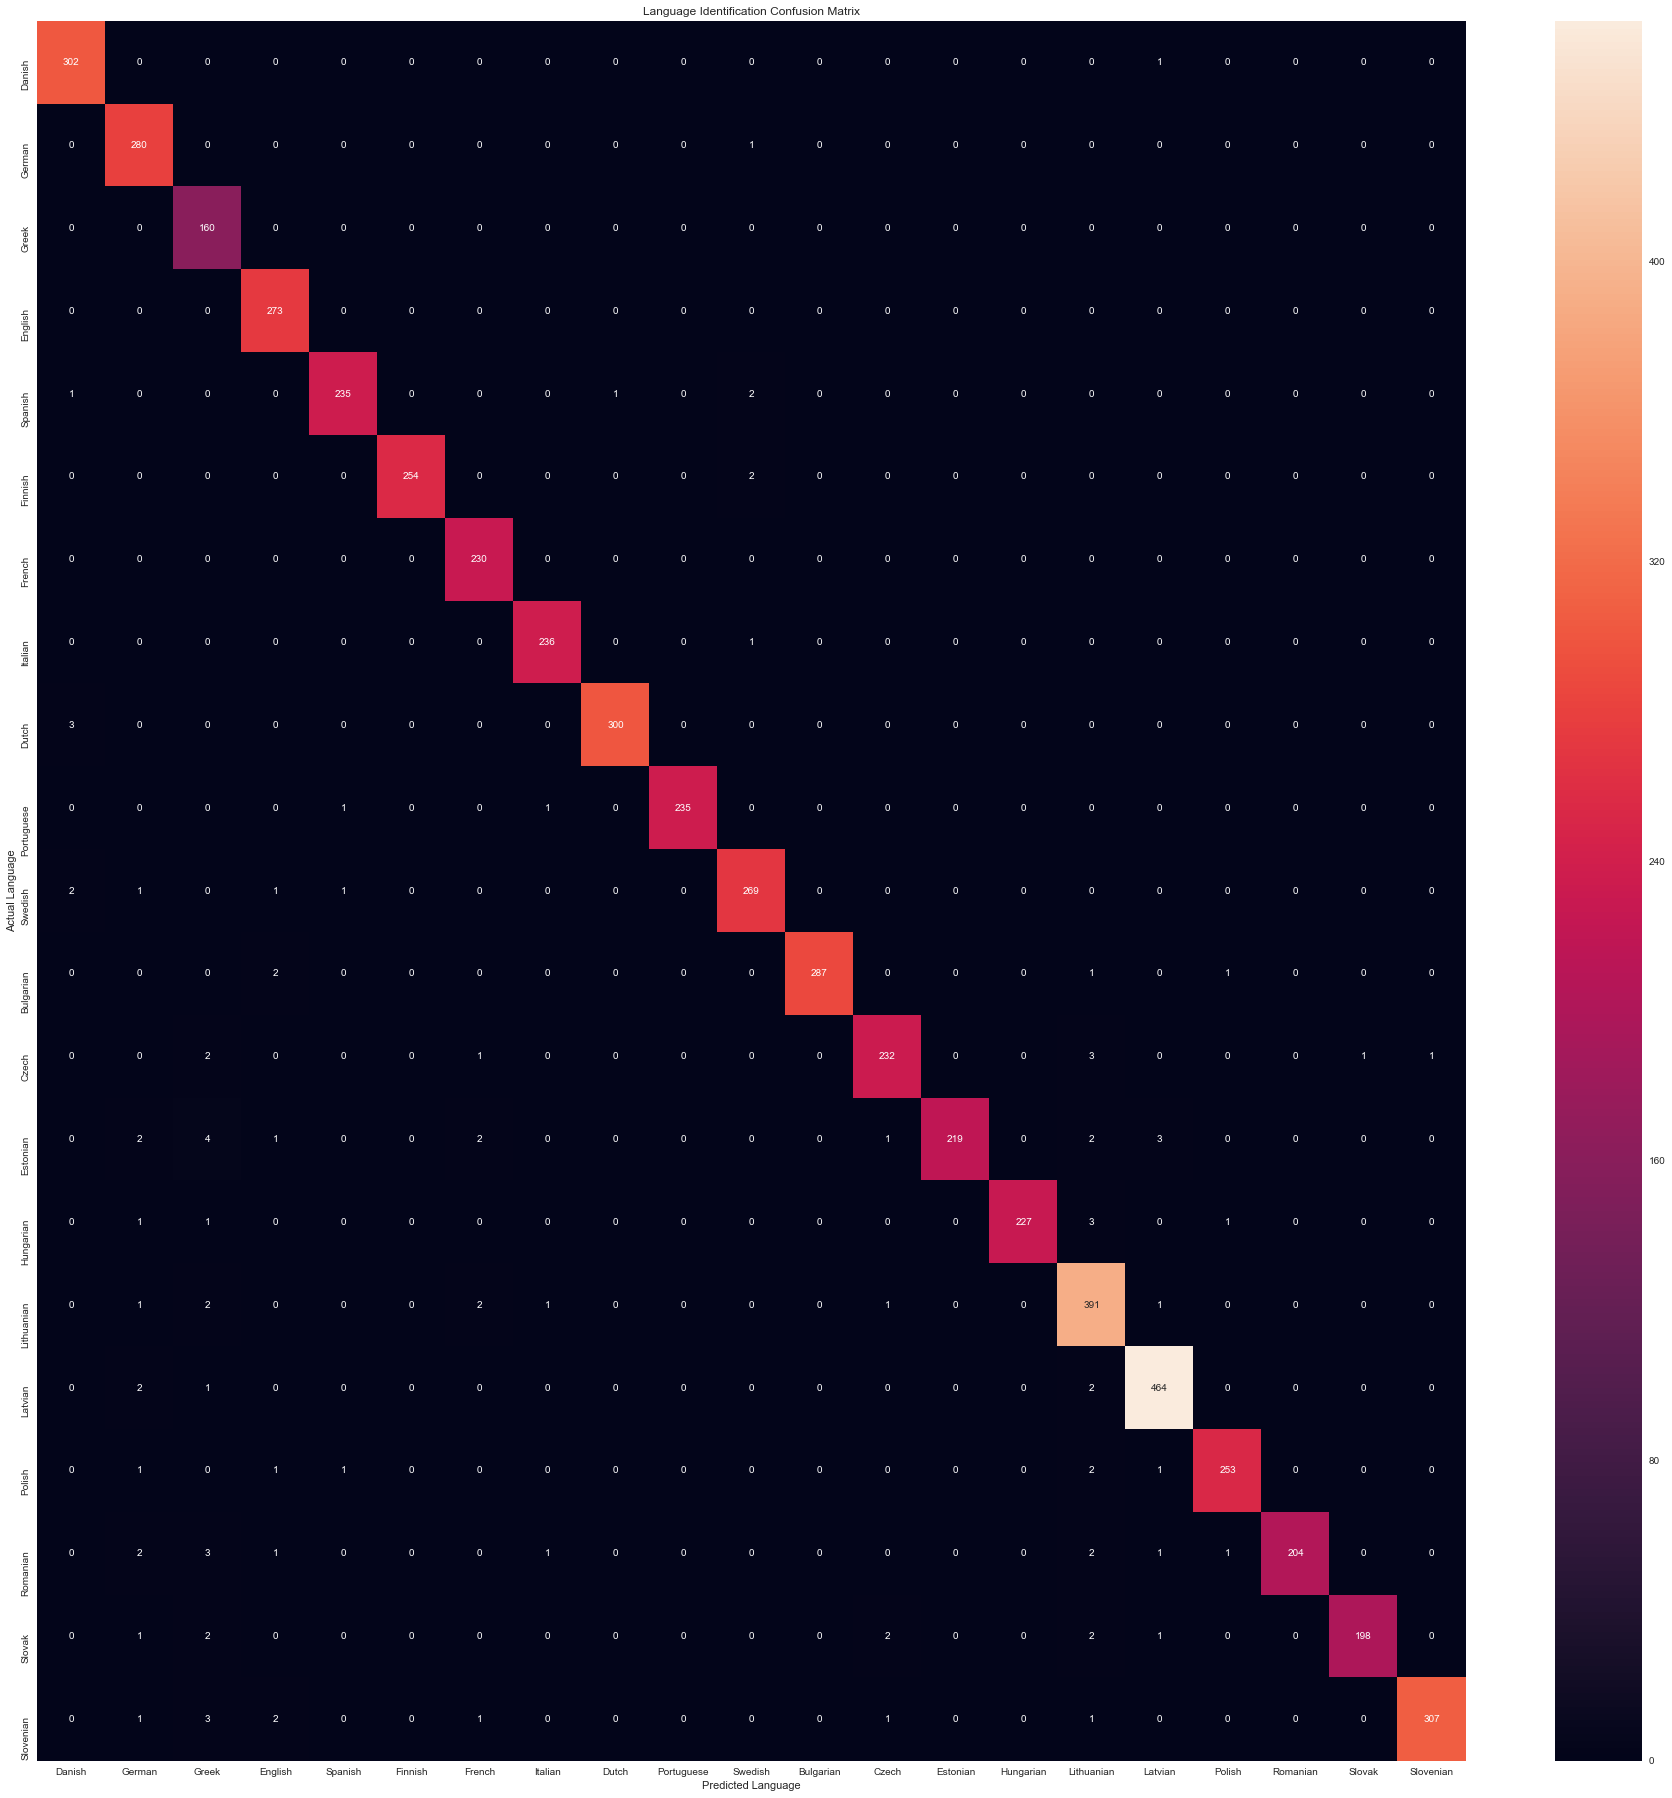

In [29]:
language_names = list(language_codes_files.keys())
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(labels.values())
ax.set_yticklabels(labels.values())

In [30]:
# Visualize Performance

test_languages(X_test, y_test, predictions)

Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

KÃ¤ytÃ¤nnÃ¶ssÃ¤ kaikki komission hyvÃ¤ksymÃ¤t tarkistukset sisÃ¤ltyvÃ¤t yhteiseen kantaan.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
IzboljÅ¡anje gospodarskih razmer v ribiÅ¡kem sektorju (glasovanje) 

10.


Prediction: Romanian
Actual Language: Romanian
Input Sentence: 
ÃŽncheierea protocolului la Acordul de parteneriat ÅŸi cooperare CE/Armenia (aderarea Republicii Bulgaria ÅŸi a RomÃ¢niei la UE) (vot)

Report: Jacek Saryusz-Wolski

7.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Ð¿Ñ€Ð¾Ñ‚Ð¾ÐºÐ¾Ð»Ð¸

Ð¡ÑŠÑÑ‚Ð°Ð² Ð½Ð° Ð´ÐµÐ»ÐµÐ³Ð°Ñ†Ð¸Ð¸Ñ‚Ðµ: Ð²Ð¶.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Entendemos que es importante la colaboraciÃ³n, el trabajo en comÃºn por parte de las dos instituciones -Parlamento y ComisiÃ³n- y que la colaboraciÃ³n que existe con la ComisiÃ³n de PolÃ­tica Regional, y concretamente con el grupo de transportes, es magnÃ­fica.


Predic

Actual Language: Bulgarian
Input Sentence: 
Ð¿Ñ€Ð¾Ñ‚Ð¾ÐºÐ¾Ð»Ð°

ÐŸÐµÑ‚Ð¸Ñ†Ð¸Ð¸: Ð²Ð¶.


Prediction: Czech
Actual Language: Czech
Input Sentence: 
Å½Ã¡dost o konzultaci s VÃ½borem regionÅ¯: ÃšÄinek a nÃ¡sledky strukturÃ¡lnÃ­ch politik na soudrÅ¾nost EvropskÃ© unie (ÄlÃ¡nek 118 jednacÃ­ho Å™Ã¡du) (hlasovÃ¡nÃ­)

3.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
CiÃ² non va imputato soltanto alla Commissione ma credo che dobbiamo attivarci piÃ¹ rapidamente per giungere a un'armonizzazione anche in questo ambito.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
protokolu)

NÄkamo sÄ“Å¾u datumi (sk.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
In deze fase is het belangrijker dat men zich concentreert op de beoordeling van de vraag hoe met dit proces het regionaal beleid van de Unie gestuurd kan worden, rekening houdend met het doel, namelijk het verkleinen van de regionale verschillen.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Se

Prediction: French
Actual Language: French
Input Sentence: 

Monsieur le PrÃ©sident, Mesdames et Messieurs, Monsieur le Commissaire, grÃ¢ce aux orientations, les Ã‰tats membres se voient offrir une ligne de conduite pour atteindre les objectifs de rÃ©forme dans le cadre de la programmation.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Wat is een rechtvaardige samenleving?


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 
Dessa Ã¤ndringsfÃ¶rslag behandlar den sociala ekonomin och behovet av att tillhandahÃ¥lla socialt riskkapital och finansiellt stÃ¶dja lokala program fÃ¶r utveckling av sysselsÃ¤ttningsmÃ¶jligheter och stÃ¤rkande av den sociala sammanhÃ¥llningen.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

Rogo-lhe que reconsidere esta decisÃ£o, porque as coisas nÃ£o se passaram assim.


Prediction: French
Actual Language: French
Input Sentence: 
Le Parlement devrait dÃ¨s lors envoyer un message en ce sens, Ã©tant donnÃ© qu'une gra

Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Kolmas tavoite koskee kaupunkien ja maaseudun kehittÃ¤mistÃ¤ tasapainoisen aluepolitiikan puitteissa.


Prediction: Lithuanian
Actual Language: Lithuanian
Input Sentence: 
protokolÄ…)

Veiksmai Ä¯gyvendinant Parlamento pozicijas ir rezoliucijas: Å¾r.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 
Jos nÃ¤in ei kÃ¤y, jos tyÃ¶nantajat jÃ¤tetÃ¤Ã¤n syrjÃ¤Ã¤n ja jos he eivÃ¤t voi osallistua nÃ¤iden rahojen hoitoon, mitÃ¤ en ainoastaan tarkoita, vaan pikemminkin sitÃ¤, etteivÃ¤t he ole edes tuensaajia, olemme menettÃ¤neet yhden tilaisuuden pÃ¤Ã¤stÃ¤ tavoitteeseemme nopeampaa tietÃ¤.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
EurÃ³pai mÅ±holdas rÃ¡diÃ³navigÃ¡ciÃ³s programok irÃ¡nyÃ­tÃ¡sa (szavazÃ¡s)

10.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
zapisnik

Razprave o primerih krÅ¡itev Älovekovih pravic, demokracije in naÄela pravne drÅ¾ave (Älen 115 Poslovnika EP)




Prediction: Czech
Actual Language: Czech
Input Sentence: 

Opravy hlasovÃ¡nÃ­ a sdÄ›lenÃ­ o Ãºmyslu hlasovat: viz zÃ¡pis

SdÄ›lenÃ­ spoleÄnÃ½ch postojÅ¯ Rady: viz zÃ¡pis

ÄŒlenstvÃ­ v meziparlamentnÃ­ch delegacÃ­ch: viz zÃ¡pis

SloÅ¾enÃ­ Parlamentu: viz zÃ¡pis

PÅ™edÃ¡nÃ­ pÅ™ijatÃ½ch textÅ¯ bÄ›hem schÅ¯ze: viz zÃ¡pis

TermÃ­ny pÅ™Ã­Å¡tÃ­ch zasedÃ¡nÃ­: viz zÃ¡pis

SchvÃ¡lenÃ­ zÃ¡pisu z pÅ™edchozÃ­ho zasedÃ¡nÃ­: viz zÃ¡pis

PÅ™edloÅ¾enÃ­ dokumentÅ¯: viz zÃ¡pis

Texty smluv dodanÃ© Radou: viz zÃ¡pis

RozhodnutÃ­ o urÄitÃ½ch dokumentech: viz zÃ¡pis

OtÃ¡zky k ÃºstnÃ­mu zodpovÄ›zenÃ­ a pÃ­semnÃ¡ prohlÃ¡Å¡enÃ­ (pÅ™edloÅ¾enÃ­): viz zÃ¡pis

PÃ­semnÃ¡ prohlÃ¡Å¡enÃ­ (ÄlÃ¡nek 116 jednacÃ­ho Å™Ã¡du): viz zÃ¡pis

NÃ¡slednÃ½ postup na zÃ¡kladÄ› usnesenÃ­ Parlamentu: viz zÃ¡pis

SloÅ¾enÃ­ Parlamentu: viz zÃ¡pis

ÄŒlenstvÃ­ ve vÃ½borech a delegacÃ­ch: viz zÃ¡pis

PodepisovÃ¡nÃ­ aktÅ¯ pÅ™ijatÃ½ch postupem spolurozhodovÃ¡nÃ­: viz zÃ¡pis

ProhlÃ¡Å¡enÃ­ o finanÄnÃ­ch zÃ¡jmech: viz zÃ¡pis

PoÅ™ad jednÃ¡nÃ



Prediction: Greek
Actual Language: Greek
Input Sentence: 
Î“Î¹Î± Ï„Î¿Î½ Î»ÏŒÎ³Î¿ Î±Ï…Ï„ÏŒ ÎºÎ¬Î½Î¿Ï…Î¼Îµ Ï„Î· ÏƒÏÏƒÏ„Î±ÏƒÎ· - ÎºÎ±Î¹ Î­Ï‡Ï‰ Ï„Î·Î½ ÎµÎ½Ï„ÏÏ€Ï‰ÏƒÎ· Ï€Ï‰Ï‚ ÎºÎ±Î¹ Î· Î•Ï€Î¹Ï„ÏÎ¿Ï€Î® ÎµÎ¯Î½Î±Î¹ Î±Î½Î¿Î¹Ï‡Ï„Î® Ï€ÏÎ¿Ï‚ Î±Ï…Ï„Î® Ï„Î· ÏƒÎºÎ­ÏˆÎ· - Î½Î± Î´Î¹ÎµÎ¾Î¬Î³Î¿Ï…Î¼Îµ ÎµÎ½Ï„ÏŒÏ‚ Ï„Î¿Ï… Î¦ÎµÎ²ÏÎ¿Ï…Î±ÏÎ¯Î¿Ï… Ï„Î· ÏƒÏ…Î¶Î®Ï„Î·ÏƒÎ· ÎµÏ€Î¯ Ï„Î¿Ï… Î¼Î±ÎºÏÎ¿Ï€ÏÏŒÎ¸ÎµÏƒÎ¼Î¿Ï… Ï€ÏÎ¿Î³ÏÎ¬Î¼Î¼Î±Ï„Î¿Ï‚ Ï„Î·Ï‚ Î•Ï€Î¹Ï„ÏÎ¿Ï€Î®Ï‚ Î­Ï‰Ï‚ Ï„Î¿ Î­Ï„Î¿Ï‚ 2005 - ÎµÎ»Ï€Î¯Î¶Ï‰ Ï€Ï‰Ï‚ ÎºÎ±Î¹ Î· Î•Ï€Î¹Ï„ÏÎ¿Ï€Î® Î¸Î± ÏƒÏ…Î¼Ï†Ï‰Î½Î®ÏƒÎµÎ¹ Î¼Î­Ï‡ÏÎ¹ Ï„ÏŒÏ„Îµ ÏŒÏƒÎ¿Î½ Î±Ï†Î¿ÏÎ¬ ÎºÎ¬Ï€Î¿Î¹Î¿ Ï€ÏÏŒÎ³ÏÎ±Î¼Î¼Î± Ï€Î¿Ï… Î¸Î± Î¼Î±Ï‚ Ï€ÏÎ¿Ï„ÎµÎ¯Î½ÎµÎ¹ - ÎºÎ±Î¹ Î½Î± Î´Î¹ÎµÎ¾Î±Î³Î¬Î³Î¿Ï…Î¼Îµ Ï„Î±Ï…Ï„ÏŒÏ‡ÏÎ¿Î½Î± Ï„Î¿Î½ Î¦ÎµÎ²ÏÎ¿Ï…Î¬ÏÎ¹Î¿ ÎºÎ±Î¹ Ï„Î· ÏƒÏ…Î¶Î®Ï„Î·ÏƒÎ· ÏƒÏ‡ÎµÏ„Î¹ÎºÎ¬ Î¼Îµ Ï„Î¿Î½ Ï€ÏÎ¿Î³ÏÎ±Î¼Î¼Î±Ï„Î¹ÏƒÎ¼ÏŒ Ï„Î¿Ï… Î½Î¿Î¼Î¿Î¸ÎµÏ„Î¹ÎºÎ¿Ï Î­ÏÎ³Î¿Ï… Ï„Î·Ï‚ Î•Ï€Î¹Ï„ÏÎ¿Ï€Î®Ï‚ Î³Î¹Î± Ï„Î¿ Î­Ï„Î¿Ï‚ 2000.


Prediction: German
Actual Language: German
Input Sentence: 
Ich muÃŸ Ihnen aber sagen, daÃŸ ich die



Prediction: Spanish
Actual Language: Spanish
Input Sentence: 
La clave ahora es consolidar y hacer permanente el progreso que se ha realizado hasta la fecha.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
ÐŸÑ€Ð¸ÑÑŠÐµÐ´Ð¸Ð½ÑÐ²Ð°Ð½Ðµ Ð½Ð° Ð‘ÑŠÐ»Ð³Ð°Ñ€Ð¸Ñ Ð¸ Ð ÑƒÐ¼ÑŠÐ½Ð¸Ñ ÐºÑŠÐ¼ ÐšÐ¾Ð½Ð²ÐµÐ½Ñ†Ð¸ÑÑ‚Ð° Ð·Ð° Ð·Ð°Ñ‰Ð¸Ñ‚Ð°Ñ‚Ð° Ð½Ð° Ñ„Ð¸Ð½Ð°Ð½ÑÐ¾Ð²Ð¸Ñ‚Ðµ Ð¸Ð½Ñ‚ÐµÑ€ÐµÑÐ¸ Ð½Ð° Ð•Ð²Ñ€Ð¾Ð¿ÐµÐ¹ÑÐºÐ¸Ñ‚Ðµ Ð¾Ð±Ñ‰Ð½Ð¾ÑÑ‚Ð¸ (Ð²Ð¾Ñ‚)

- Informe: Jean-Marie Cavada (A6-0360-2007)

8.


Prediction: Italian
Actual Language: Italian
Input Sentence: 
Il collega Koch ha dovuto preparare la sua pregevole relazione in quanto i lavori del CEN e anche quelli della Commissione economica delle Nazioni Unite non sono stati svolti con la dovuta celeritÃ .


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
StratÃ©giai irÃ¡nymutatÃ¡sok a vidÃ©kfejlesztÃ©shez (2007-2013) (szavazÃ¡s)

3.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

(Suosionosoituksia)

KyllÃ¤, suul

Actual Language: Spanish
Input Sentence: 

Mientras que en el Quinto Informe sobre la situaciÃ³n de las regiones el desempleo en las regiones pobres era siete veces mÃ¡s alto que en las regiones ricas, el Sexto informe habla ya de un desempleo ocho veces mayor, aunque los recursos de los Fondos estructurales europeos fluyen hacia esas regiones.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
00.05)

Otwarcie posiedzenia

(La seduta Ã¨ aperta alle 9.00)

Debaty na temat przypadkÃ³w Å‚amania praw czÅ‚owieka, demokracji i paÅ„stwa prawa (ogÅ‚oszenie zÅ‚oÅ¼onych projektÃ³w rezolucji): patrz protokÃ³Å‚

1.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
zapisnik

Podpis aktov, sprejetih v postopku soodloÄanja: glej zapisnik

SporoÄila predsedstva: gl.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
2005.


Prediction: German
Actual Language: German
Input Sentence: 

Beim Abfassen des Protokolls werden wir mit groÃŸer Sorgfalt vorgehen.



Input Sentence: 

Az Ã¼lÃ©s megnyitÃ¡sa

(Se abre la sesiÃ³n a las 9.05 horas)

2.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 

Otvoritev seje

(Die Sitzung wird um 9.00 Uhr erÃ¶ffnet.)


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 

Os factos ocorridos na semana passada - que tiveram origem Ã  margem da ConferÃªncia dos Presidentes, e que a utilizaram sÃ³ para corroborar e ratificar decisÃµes tomadas fora dela - criam um dilema: ou a ComissÃ£o nÃ£o se encontra em condiÃ§Ãµes de apresentar esse programa (e nesse caso conviria que o explicasse.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
Zmeny a doplnenia ÄlÃ¡nkov 3 a 4 rokovacieho poriadku EurÃ³pskeho parlamentu (hlasovanie)

19.


Prediction: Polish
Actual Language: Polish
Input Sentence: 
Absolutorium 2004: Sekcja VIII B, Europejski Inspektor Ochrony Danych (gÅ‚osowanie)

24.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Ik vraag me dus af waar het aan li

Input Sentence: 

De vraag waarom dat element vergeten is, is tot nu toe niet beantwoord, en daarom stelt het Parlement een aantal hoofdeisen.


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Para terminar, quisiera destacar que las polÃ­ticas estructurales en su conjunto requieren mayor flexibilidad, de suerte que se adapten a las circunstancias cambiantes y que respondan de ese modo a los nuevos retos y oportunidades que se presentan con la llegada del nuevo milenio, para el que todos hacemos los mejores votos.


Prediction: Hungarian
Actual Language: Hungarian
Input Sentence: 
Ã©s 4. cikkÃ©nek mÃ³dosÃ­tÃ¡sa (szavazÃ¡s)

19.


Prediction: Slovak
Actual Language: Slovak
Input Sentence: 
RegionÃ¡lna stratÃ©gia a programy pre Mercosur a LatinskÃº Ameriku (hlasovanie)

- Propuesta de resoluciÃ³n:

17.


Prediction: English
Actual Language: English
Input Sentence: 
That way the much-trumpeted need for transparency in the use of these funds and the temptation to draw unnece

Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Dit geldt met name voor de gebieden waarop deze samenhang ontbreekt.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Homologacija motornih vozil glede prednjega vidnega polja voznika motornega vozila (glasovanje)

3.


Prediction: Greek
Actual Language: Greek
Input Sentence: 

Î˜Î± Î®Î¸ÎµÎ»Î± Î½Î± ÎµÏ€Î¹ÏƒÏ„Î®ÏƒÏ‰ Ï„Î·Î½ Ï€ÏÎ¿ÏƒÎ¿Ï‡Î® Ï„Ï‰Î½ Î±ÎºÏÎ¿Î±Ï„ÏŽÎ½ ÏƒÏ„Î¹Ï‚ Ï„ÏÎ¿Ï€Î¿Î»Î¿Î³Î¯ÎµÏ‚ Î±ÏÎ¹Î¸.


Prediction: German
Actual Language: German
Input Sentence: 
Und die Erfahrung, daÃŸ wirtschaftliche Entwicklung allein nicht dazu beitrÃ¤gt, Arbeitslosigkeit abzubauen, untermauert doch die Tatsache, daÃŸ man mindestens 3 % Steigerung des Bruttosozialprodukts benÃ¶tigt, um Ã¼berhaupt zusÃ¤tzliche ArbeitsplÃ¤tze zu schaffen.


Prediction: Slovenian
Actual Language: Slovenian
Input Sentence: 
Okvirni program za konkurenÄnost in inovativnost (2007-2013) (glasovanje)

4.


Prediction: Romanian
Actual Language: Romanian

Actual Language: Latvian
Input Sentence: 
Risku un krÄ«Å¾u pÄrvaldÄ«ba lauksaimniecÄ«bÄ (balsojums)

8.


Prediction: Swedish
Actual Language: Swedish
Input Sentence: 

KÃ¤ra kollega!


Prediction: Spanish
Actual Language: Spanish
Input Sentence: 

Las enmiendas que se han presentado y que han sido aprobadas por unanimidad en la comisiÃ³n se refieren precisamente en dos casos a este modificado procedimiento de comitologÃ­a.


Prediction: Greek
Actual Language: Romanian
Input Sentence: 

Ordinea de zi a urmÄƒtoarei ÅŸedinÅ£e: a se vedea procesul-verbal

Ridicarea ÅŸedinÅ£ei

(" ÏƒÏ…Î½ÎµÎ´ÏÎ¯Î±ÏƒÎ· Î´Î¹Î±ÎºÏŒÏ€Ï„ÎµÏ„Î±Î¹ ÏƒÏ„Î¹Ï‚ 11.20 Î¼.Î¼.)


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
MÐ°ÐºÑÐ¸Ð¼Ð°Ð»Ð½Ð° Ð¿Ñ€Ð¾ÐµÐºÑ‚Ð½Ð° ÑÐºÐ¾Ñ€Ð¾ÑÑ‚ Ð¸ Ñ‚Ð¾Ð²Ð°Ñ€Ð½Ð¸ Ð¿Ð»Ð°Ñ‚Ñ„Ð¾Ñ€Ð¼Ð¸ Ð½Ð° ÐºÐ¾Ð»ÐµÑÐ½Ð¸Ñ‚Ðµ ÑÐµÐ»ÑÐºÐ¾ÑÑ‚Ð¾Ð¿Ð°Ð½ÑÐºÐ¸ Ð¸Ð»Ð¸ Ð³Ð¾Ñ€ÑÐºÐ¸ Ñ‚Ñ€Ð°ÐºÑ‚Ð¾Ñ€Ð¸ (Ð²Ð¾Ñ‚)

- Rapport Wallis

7.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Dit beleid wordt do

Actual Language: Estonian
Input Sentence: 
Veinituru Ã¼hine korraldus (hÃ¤Ã¤letus)

10.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
protokolu)

Parlamenta sastÄvs (sk.


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 
Ð“Ð¾Ð´Ð¸ÑˆÐ½Ð¸ÑÑ‚ Ð´Ð¾ÐºÐ»Ð°Ð´ Ð½Ð° Ð•Ð˜Ð‘ Ð·Ð° 2005 Ð³.


Prediction: German
Actual Language: German
Input Sentence: 
Erstens: Wir muÃŸten formal tÃ¤tig werden, um den Forderungen der Richtlinie 96/35/EG gerecht zu werden, die die Mitgliedstaaten zur Einsetzung von Gefahrgutbeauftragten bzw.


Prediction: Portuguese
Actual Language: Portuguese
Input Sentence: 
A experiÃªncia do passado demonstra que, na nossa qualidade de representantes eleitos do contribuinte europeu, deverÃ­amos, ou antes, devemos, exigir verticalidade e transparÃªncia na utilizaÃ§Ã£o e na auditoria destas dotaÃ§Ãµes financeiras.


Prediction: Latvian
Actual Language: Latvian
Input Sentence: 
Darba Å†Ä“mÄ“ju aizsardzÄ«ba pret risku saistÄ«bÄ ar azbesta iedarbÄ«bu (


Prediction: Bulgarian
Actual Language: Bulgarian
Input Sentence: 

Ð˜Ð·Ð±Ð¾Ñ€ Ð½Ð° ÐºÐ²ÐµÑÑ‚Ð¾Ñ€Ð¸ Ð½Ð° Ð•Ð²Ñ€Ð¾Ð¿ÐµÐ¹ÑÐºÐ¸Ñ Ð¿Ð°Ñ€Ð»Ð°Ð¼ÐµÐ½Ñ‚ (ÑÑ€Ð¾Ðº Ð·Ð° Ð´ÐµÐ¿Ð¾Ð·Ð¸Ñ€Ð°Ð½Ðµ Ð½Ð° ÐºÐ°Ð½Ð´Ð¸Ð´Ð°Ñ‚ÑƒÑ€Ð¸): Ð²Ð¶.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 
Ook wil ik laten weten, mevrouw de Voorzitter, dat wij als Commissie bereid en klaar zijn om dat debat op het gepaste moment te houden.


Prediction: Finnish
Actual Language: Finnish
Input Sentence: 

Arvoisa puhemies, kollegani Evansin tavoin minulla on suuri ilo saada puheenvuoro ja pitÃ¤Ã¤ parlamentille ensimmÃ¤inen puheeni tÃ¤stÃ¤ hyvin tÃ¤rkeÃ¤stÃ¤ aiheesta, varsinkin koska edustan sellaista Yhdistyneen kuningaskunnan aluetta, nimittÃ¤in West Midlandsia, joka on tÃ¤hÃ¤n asti pÃ¤Ã¤ssyt nauttimaan erityisesti tavoitteen 2 alueiden rahoituksesta.


Prediction: Dutch
Actual Language: Dutch
Input Sentence: 

Daarom moeten wij deze week de nodige beslissingen nemen, en dan kunnen wij alleen maar hopen dat er in 2001